# How does the performance of a distributional model change as we train in on more and more labelled data?

 - Pennington el al (2014) report `word2vec`'s performance at the word analogy task and a range of word similarity task improves with more data. 
 - My own experiments (in `euroscipy_demo` notebook) show performance at the analogy task roughly scales like $log(x)$

Let's investigate if the same holds for the document classification task. For simiplicity, we only look at `word2vec` vectors with simple composion on the Reuters data set.

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def get_exp_ids_for_varying_amounts_of_unlabelled(lab_corpus, unlab='wiki'):
    query_dict = {'expansions__vectors__rep': 0, 
                  'expansions__k':3,
                  'labelled':lab_corpus,
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                #           'vectors__unlabelled_percentage__in': [70,80], # todo remove this
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
                'expansions__vectors__unlabelled': unlab,
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
    return Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage',
                                                           'expansions__vectors__composer').values_list('id', flat=True)
def plot(lab_corpus, unlab, token_count):
    ids = get_exp_ids_for_varying_amounts_of_unlabelled(lab_corpus, unlab)
    print(len(ids), 'ids in total:', ids)
    cols = {'Composer':'expansions__vectors__composer',
            'percent':'expansions__vectors__unlabelled_percentage',
            'unlab': 'expansions__vectors__unlabelled'}
    df = dataframe_from_exp_ids(ids, cols).convert_objects(convert_numeric=True)
    df['tokens'] = token_count * df.percent.values / 100
    ax = sns.tsplot(df, time='tokens', condition='Composer', value='Accuracy', 
                    unit='folds', linewidth=4, ci=68);
    # remove axis labels  
    ax.set(xlabel='Tokens', ylabel='Accuracy')

    # random baseline
    plt.axhline(random_vect_baseline(lab_corpus), label='RandV', color='black')
    plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
    return df, ax

32 ids in total: [101, 113, 107, 119, 102, 114, 108, 120, 75, 77, 76, 78, 103, 115, 109, 121, 104, 116, 110, 122, '...(remaining elements truncated)...']
folds has 16000 values
Composer has 16000 values
unlab has 16000 values
percent has 16000 values
Accuracy has 16000 values


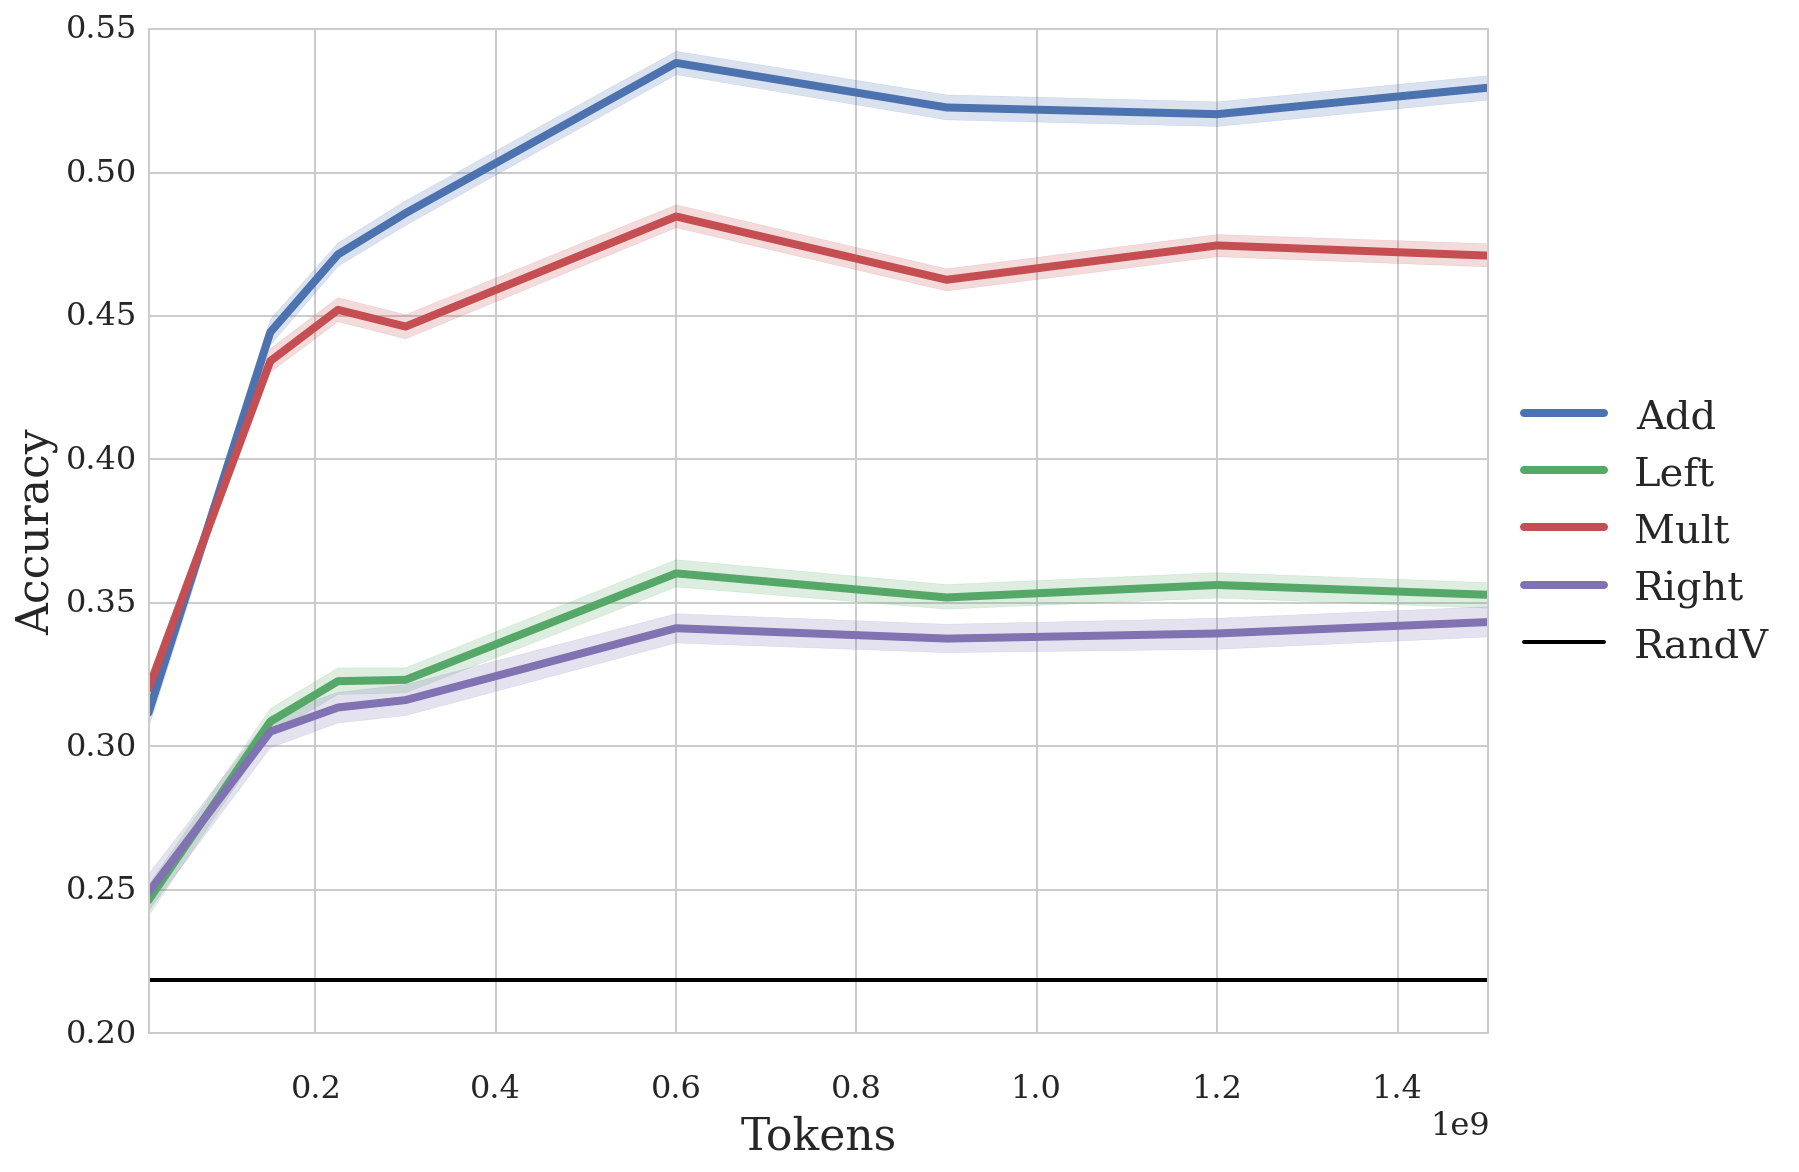

In [3]:
df1, ax = plot('amazon_grouped-tagged', 'wiki', 1500000000)
plt.savefig('plot-w2v_learning_curve_amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

45 ids in total: [125, 147, 136, 158, 126, 148, 137, 159, 364, 127, 149, 138, 160, 128, 150, 139, 161, 130, 152, 141, '...(remaining elements truncated)...']
folds has 22500 values
Composer has 22500 values
unlab has 22500 values
percent has 22500 values
Accuracy has 22500 values


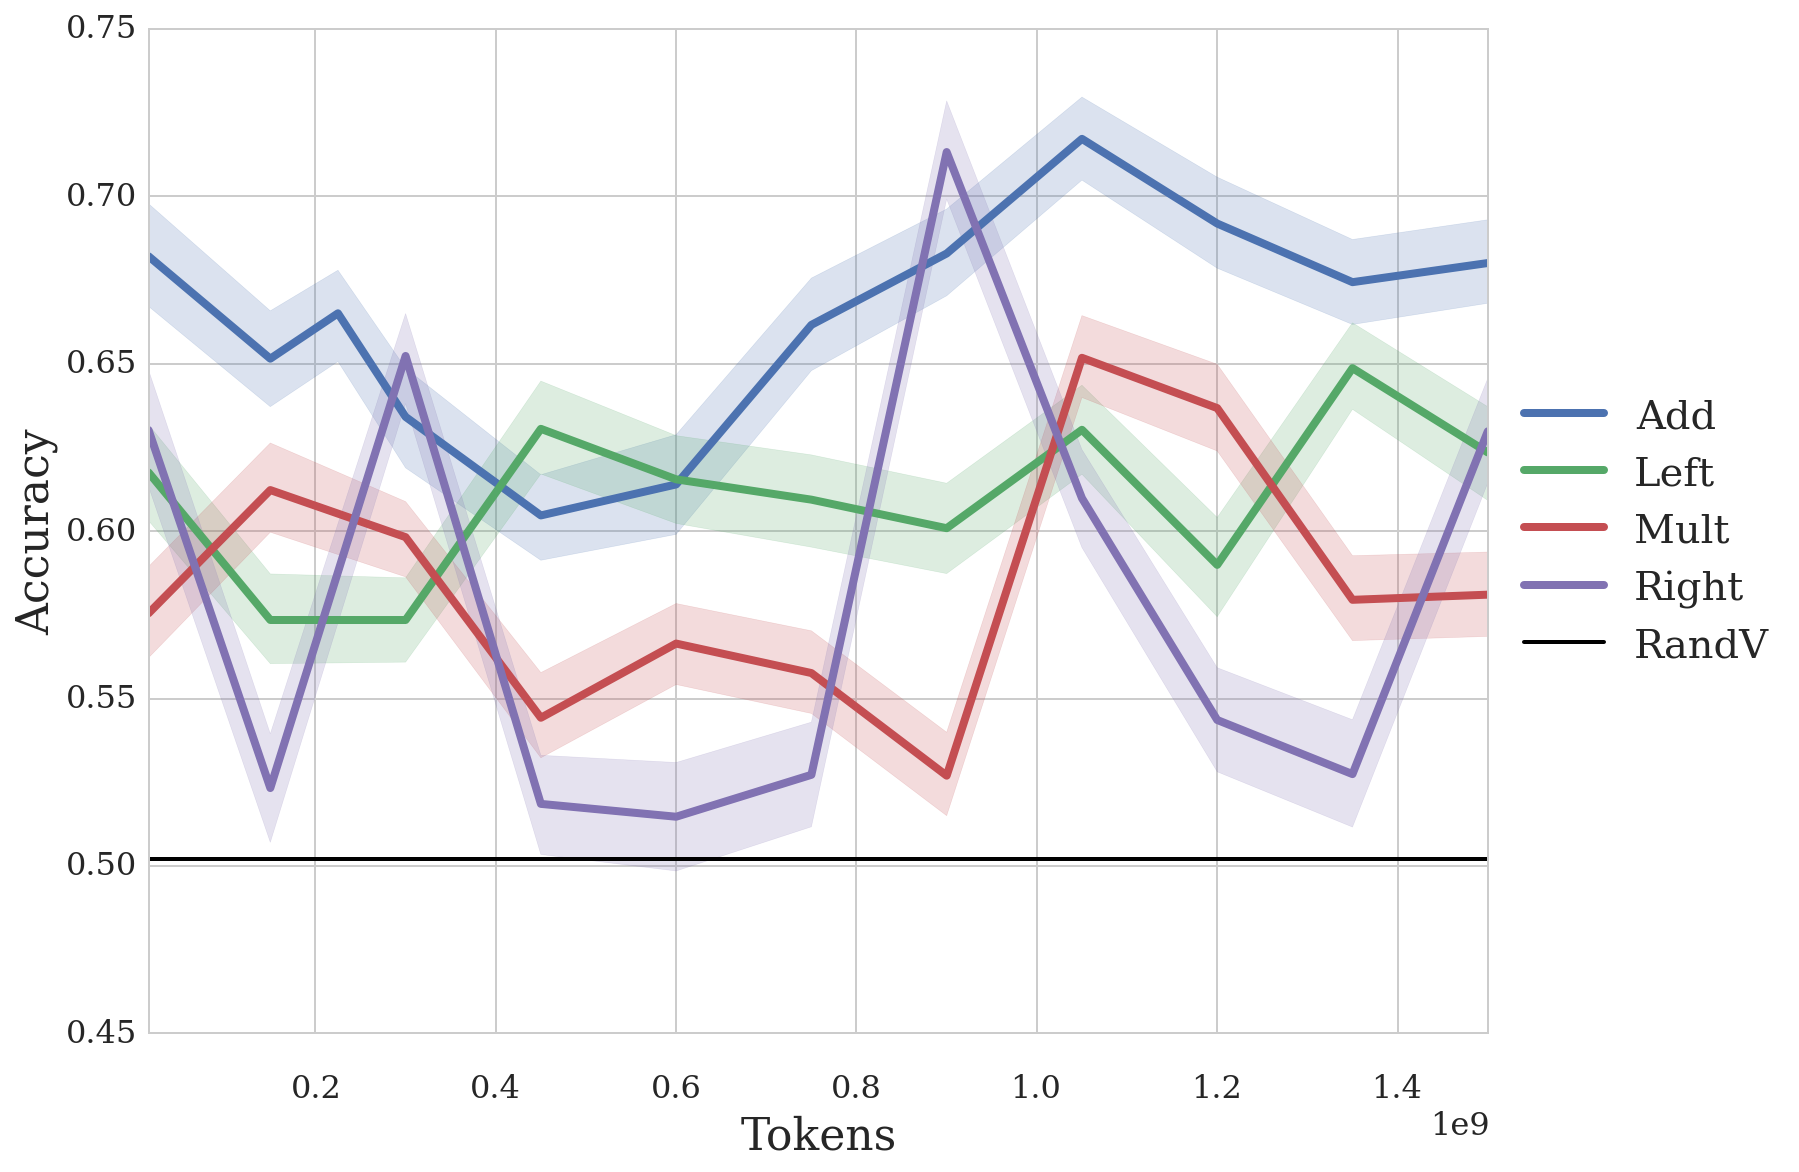

In [6]:
plot('reuters21578/r8-tagged-grouped', 'wiki', 1500000000)
plt.savefig('plot-w2v_learning_curve_r2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# A different style of plot (with smoothing) 

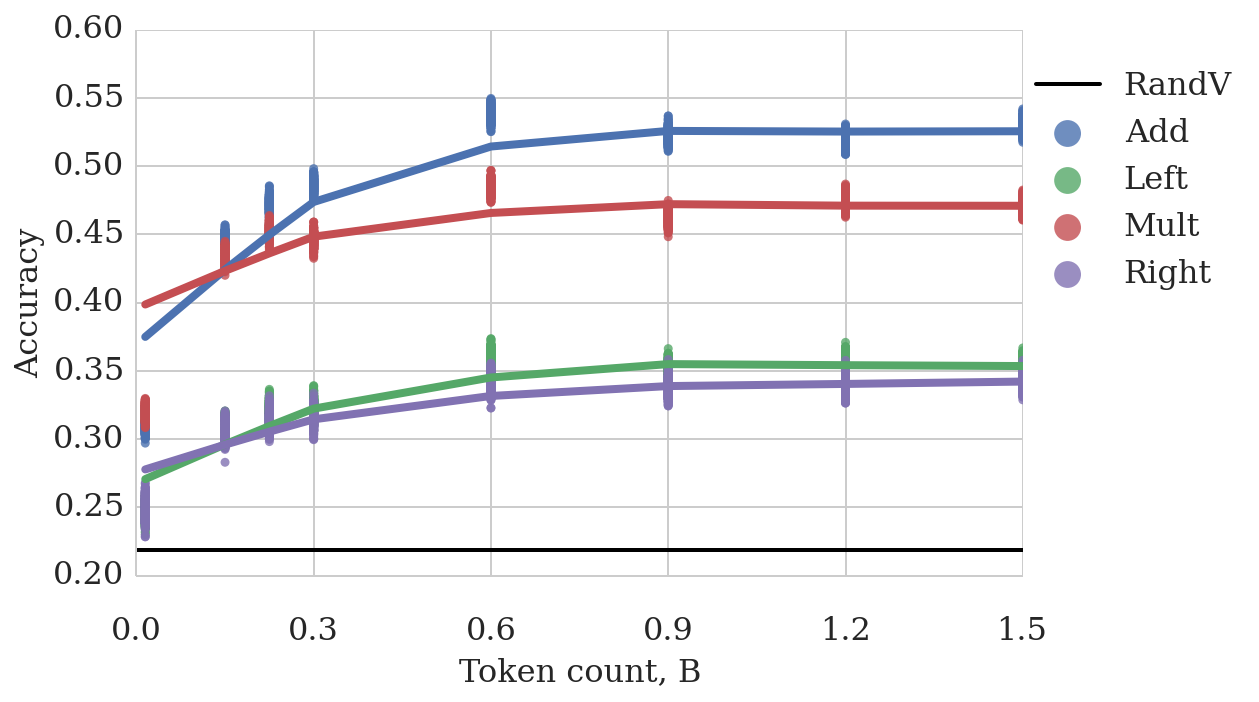

In [5]:
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.labelsize'] = 16

# do main plot
df['Algorithm'] = df.Composer
g = sns.lmplot('percent', 'Accuracy', df, hue='Algorithm', lowess=True, 
               line_kws={"linewidth": 4}, # line size
               legend=False, # hide legend for now, I'll show it later
               aspect=1.5);

labels = np.arange(0, 101, 20) * 0.01 * 1.5 # convert percent of corpus to a rough token count
g.set(xlim=(0,100), xticklabels=labels, xlabel='Token count, B')

# add random baseline
plt.axhline(random_vect_baseline(), color='k', label='RandV');

# add a legend with extra bits and bobs
plt.legend(markerscale=3,
#            bbox_to_anchor=(0., 1.02, 1., .102), 
           bbox_to_anchor=(1., .5), 
           loc=3,
           ncol=1,
           borderaxespad=0.)
g.savefig('plot-w2v_learning_curve_amazon2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

#---------------------------------------------------------------------------
#---------------------------------------------------------------------------
# Notes on code below
In earlier iterations of this experiment we used Reuters data, where there was large variation between accuracies of multiple runs of the `word2vec`. The code below looks into why that might be the case. These differences no longer exist, so the code below is probably useless.

# Why is multiply so unstable?
Things to look at
- <s>compare vectors between multiple runs (before and after composition)</s>. The space is completely different, this makes no sense.
 - compare neighbours of a sample of entries between runs
  - without any constraints, out of the full vocabulary
  - out of the neighbours present in the labelled data set
      - redoing experiments [218, 313, 314] and [225, 315, 316] with stats enabled. These are word2vec repeated runs at 100% of gigaw with Add/Mult composer respectively
  
- Could the whole variation be simply down to the small size of Reuters? Would using Amazon help? 
  - in general error bounds due to classification task are much smaller on Amazon (~1%) as apposed to ~3-4% on Reuters

- Performance of `w2v` models I've trained on google's analogy task
    - can't easily calculate as I have stemmed and added a pos tar => syntactic part of test is impossible to do
    - compute something like Precision@K/MAP instead of accuracy of top neighbour

 - Neighbour do not overlap much (not to mention their order)
 - Should I report averaged performance across all runs of `word2vec`?
 
If the neighbours vary so much, why is the performance of some composers so stable? 
  - Do some composers "magnify" differences in input vectors?
  - Is it a matter of vocabulary coverage? the neighbours that we find here are different to the one the classifier finds